# Digital House - Data Science a Distancia

## Trabajo Práctico 2



### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Mayo 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import statsmodels.api as sm

In [5]:
# Ignore some warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

---
#### Dataset

In [6]:
data_final_url = "../Data/properatti_final5.csv"
data = pd.read_csv(data_final_url, encoding="utf-8")


---
#### Seleccionar, renombrar y ajustar valores de las características

In [7]:
if 'Unnamed: 0' in list(data.columns) :
    data = data.drop(columns=['Unnamed: 0']).copy()

In [8]:
data.rename(columns={'property_type' : 'tipo'}, inplace=True)
data.rename(columns={'price_aprox_usd' : 'precio'}, inplace=True)
data.rename(columns={'surface_covered_in_m2' : 'superficie'}, inplace=True)

In [9]:
# Trabajar con precio en miles de dólares
data['precio'] = (data['precio'] / 1000).round(3)

In [10]:
# Ajustar la cantidad de ambientes de [1, 7 o más]
data['ambientes'] = data['ambientes'].apply(lambda x : x if x < 7 else 7) 

In [11]:
# Ajustar la cantidad de baños de [1, 3 o más]
data['baños'] = data['baños'].apply(lambda x : x if x < 3 else 3)

---
#### Dummies

In [12]:
dummies = pd.get_dummies(data=data['tipo'], drop_first=True)
dummies.index = data.index
data = pd.concat([data, dummies], axis=1)

---

In [13]:
data.shape

(47037, 18)

In [14]:
data.head()

,tipo,place_name,state_name,precio,superficie,ambientes,baños,balcón,cochera,parrilla,pileta,amoblado,lavadero,patio,terraza,jardin,apartment,house
0,apartment,Mataderos,Capital Federal,72.0,55.0,2.0,1.0,0,0,0,0,0,1,0,0,0,1,0
1,PH,Munro,Bs.As. G.B.A. Zona Norte,130.0,78.0,1.0,1.0,0,0,0,0,0,1,1,0,0,0,0
2,apartment,Belgrano,Capital Federal,138.0,40.0,1.0,1.0,0,0,0,1,0,0,0,0,0,1,0
3,apartment,Belgrano,Capital Federal,195.0,60.0,1.0,1.0,0,0,0,1,0,0,0,0,0,1,0
4,apartment,Palermo Soho,Capital Federal,111.7,30.0,1.0,1.0,1,0,0,1,0,0,0,1,0,1,0


---


In [15]:

sns.set()
plt.style.use('seaborn')

sns.mpl.rcParams['axes.titlesize'] = 20
sns.mpl.rcParams['axes.labelsize'] = 16


In [16]:
features = ['apartment', 'house', 'superficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']
target = 'precio'

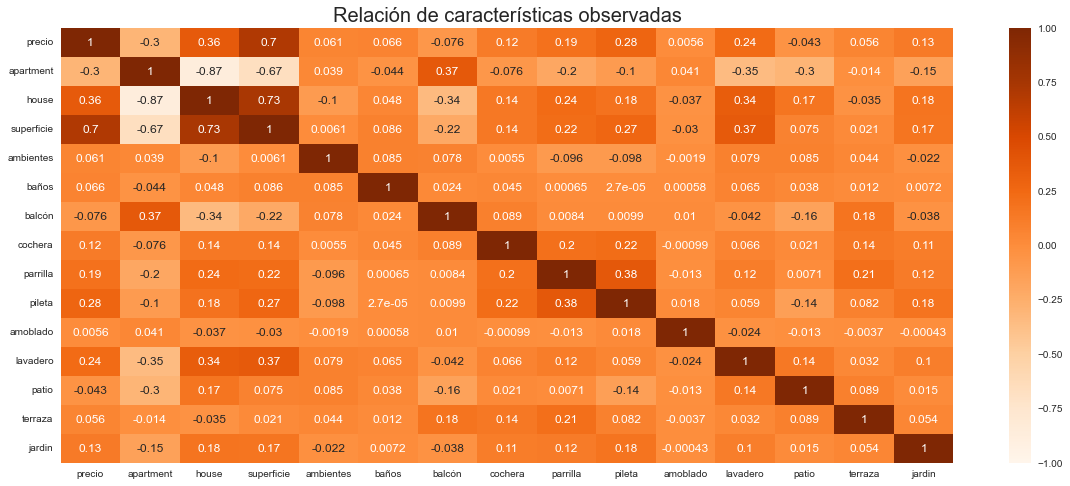

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data[[target] + features].corr(), annot=True, vmin=-1, vmax=1, cmap='Oranges', ax=ax)
ax.set(title='Relación de características observadas')
plt.show()

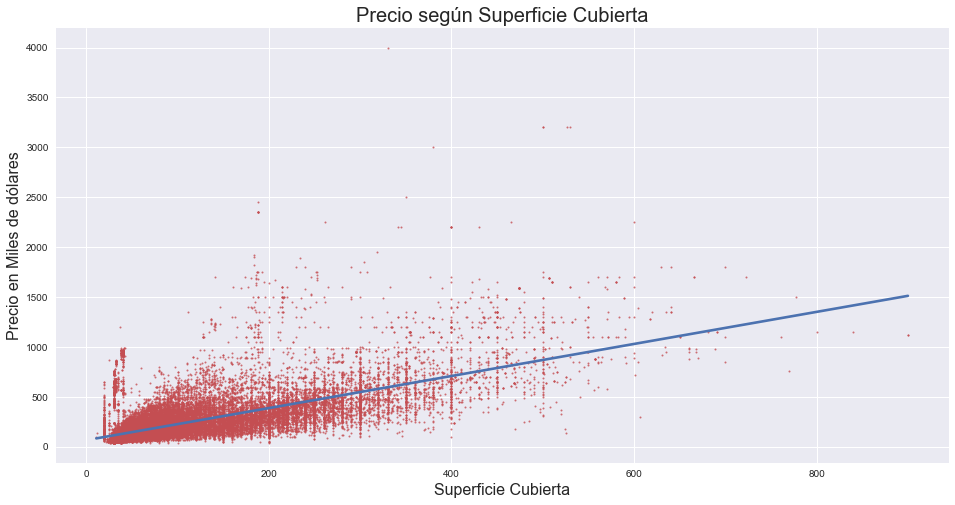

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(data=data, x='superficie', y='precio', ci=None, scatter_kws={'color':'r', 's':4}, ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.show()

---
#### Variables calculadas

In [19]:
data['logprecio'] = np.log(data['precio'])

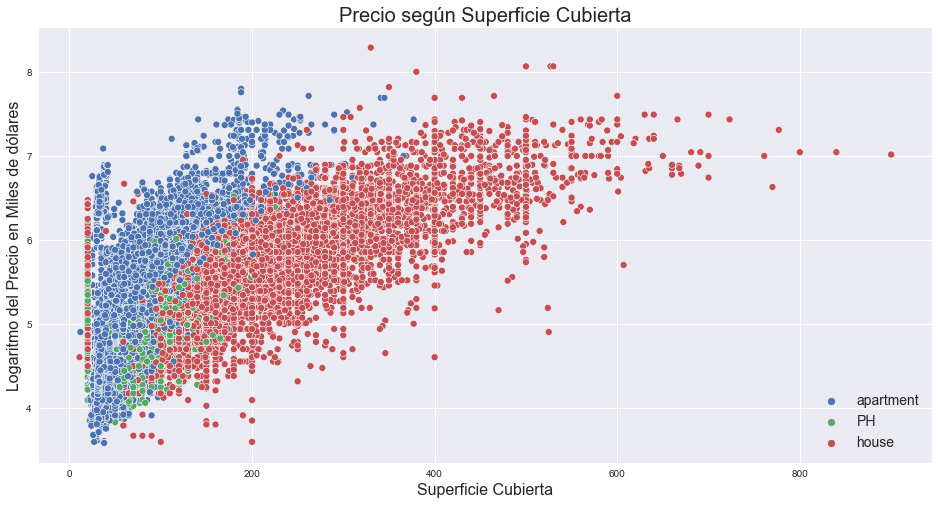

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=data, x='superficie', y='logprecio', ci=None, hue='tipo', ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Logaritmo del Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.legend(loc='lower right', fontsize=14)
plt.show()

---



In [21]:
def train_LinearRegression(X, y) :
    u""" Performs Ordinary Least Squares linear regression from Scikit-Learn linear models

    Args:
        * X array of array of features values
        * y array of target values
    Returns:
        a model fit objetct and a dataframe with metrics; MAE sqrt MSE, ^2 adj

    """
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    ymodel = model.predict(Xtrain)
    ypred = model.predict(Xtest)
    
    df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame(columns=['Features'], data=[ str(list(X.columns)) ])], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['MAE'], data=[ mean_absolute_error(ytest, ypred).round(3) ])], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['sqrt MSE'], data=[ np.sqrt(mean_squared_error(ytest, ypred)).round(3) ])], axis=1)

    r2_train = (1 - (1 - r2_score(ytrain, ymodel)) * ((len(ytrain) - 1) / (len(ytrain) - len(X.columns) - 1) )).round(3)
    
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj train'], data=[ r2_train ])], axis=1)

    r2_test = (1 - (1 - r2_score(ytest, ypred)) * ((len(ytest) - 1) / (len(ytest) - len(X.columns) - 1) )).round(3)
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj test'], data=[ r2_test ])], axis=1)
    
    return model, df, Xtest, ytest


---
### Train models


In [22]:

y = data['precio']
metrics = pd.DataFrame()

data['s2'] = data['superficie'] ** 2
data['s3'] = data['superficie'] ** 3
data['s4'] = data['superficie'] ** 4


In [23]:

features = ['apartment', 'house', 'superficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [24]:

features = ['apartment', 'house', 'superficie',
            's2',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [25]:

features = ['apartment', 'house', 'superficie',
            's2', 's3',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [26]:

features = ['apartment', 'house', 'superficie',
            's2', 's3', 's4',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [27]:
pd.options.display.max_colwidth = 120

In [28]:
display(metrics.head(20))

,Features,MAE,sqrt MSE,R^2 adj train,R^2 adj test
0,"['apartment', 'house', 'superficie', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'l...",78.928,142.258,0.560,0.542
0,"['apartment', 'house', 'superficie', 's2', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta', 'amoblad...",78.524,142.130,0.562,0.542
0,"['apartment', 'house', 'superficie', 's2', 's3', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta', 'a...",78.227,142.146,0.563,0.542
0,"['apartment', 'house', 'superficie', 's2', 's3', 's4', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pilet...",77.634,142.010,0.565,0.543


In [29]:

ols = sm.OLS(y, sm.add_constant(X)).fit()

display(ols.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     3511.
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:52:05   Log-Likelihood:            -2.9795e+05
No. Observations:               47037   AIC:                         5.959e+05
Df Residuals:                   47019   BIC:                         5.961e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -92.2975      5.231    -17.643      0.000    -102.551     -82.044
apartment     79.7509      3.003     26.554      0.000      73.864      85.637
house        -89.2610      3.384    -26.375      0.000     -95.894     -82.628
superficie     3.5133      0.077     45.771      0.000       3.363       3.664
s2            -0.0080      0.000    -16.189      0.000      -0.009      -0.007
s3          1.657e-05   1.17e-06     14.219      0.000    1.43e-05    1.88e-05
s4         -1.148e-08   8.66e-10    -13.258      0.000   -1.32e-08   -9.79e-09
ambientes      5.3237      0.578      9.218      0.000       4.192       6.456
baños         -6.4500      3.262     -1.978      0.048     -12.843      -0.057
balcón        -6.8475      1.430     -4.790      0.000      -9.649      -4.046
cochera        0.0209      1.339      0.016      0.988      -2.604       2.646
parrilla      18.7551      1.466     12.798      0.000      15.883      21.628
pileta        29.2608      1.551     18.862      0.000      26.220      32.301
amoblado      54.0652      8.749      6.179      0.000      36.916      71.214
lavadero       2.8197      1.461      1.930      0.054      -0.044       5.684
patio        -18.9751      1.911     -9.929      0.000     -22.721     -15.229
terraza        8.9826      1.492      6.020      0.000       6.058      11.907
jardin         6.2401      2.301      2.711      0.007       1.729      10.751
==============================================================================
Omnibus:                    41459.768   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2829672.834
Skew:                           3.950   Prob(JB):                         0.00
Kurtosis:                      40.167   Cond. No.                     1.48e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# departamento de 1 m2 cubierto sin cochera ni pileta
#import math
#my_X = [[70, 70*70, 0, 0]]
#my_y = model.predict(my_X)[0]
#display(my_y, math.exp(my_y))

---
### Gauss-Markov


In [31]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - bserverd features
    * ytest - observed values
    """

    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x=ypred, y=ytest, lowess=True, line_kws={'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top=1.5, wspace=2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return


In [32]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
#gauss_markov_test(Xtest, ytest)

---